In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import scipy.io

In [2]:
sub_num = '1'
trial_num = ['1','2','3']

#os.path.abspath("../data/cwd/mydir/myfile.txt")
trial_df = {}

for trial in trial_num:
    path = os.path.abspath("../data/02_processed/sub_"+sub_num+"/trial_"+trial+"_combined.csv")
    trial_df[int(trial)-1] = pd.read_csv(path)


In [3]:
#trial_df[0].isnull().sum()

In [4]:
# FILTER AND REPLACE
# GENERATE Differentials and add new columns 
# Remove null values and outliers
# Segment
# Choose 6 points
# RNN

In [5]:
def lowpass_filter(time, raw_signal, order=2, low_pass=10, sfreq=1000, show=0):
    
    from scipy import signal
    
    low_pass = low_pass/sfreq
    b, a = scipy.signal.butter(order, low_pass, btype='lowpass')
    filtered_signal = scipy.signal.filtfilt(b, a, raw_signal)#imu_rectified)
    
    if show ==1:
        plt.figure(1, figsize=(15,8))
        plt.subplot(2,5,1)
        plt.plot(time[0:10000],raw_signal[0:10000])
        plt.subplot(2,5,2)
        plt.plot(time[0:10000],filtered_signal[0:10000])
        plt.subplot(2,5,3)
        plt.plot(time[0:1000],raw_signal[0:1000])
        plt.subplot(2,5,4)
        plt.plot(time[0:1000],filtered_signal[0:1000])
        plt.subplot(2,5,5)
        plt.plot(time[0:1000],raw_signal[0:1000])
        plt.plot(time[0:1000],filtered_signal[0:1000],'r')
        plt.show()
    
    return filtered_signal

In [6]:
def filter_emg(time, emg, low_pass=10, sfreq=1000, high_band=20, low_band=450, show=0):
    import scipy as sp
    import matplotlib.pyplot as plt
    
    """
    time: Time data
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    if show == 1:
    
        # plot graphs
        fig = plt.figure()
        
        ax1 = plt.subplot(1, 4, 1)
        ax1.set_title('Unfiltered,' + '\n' + 'unrectified EMG')
        ax1.plot(time, emg)
        ax1.locator_params(axis='x', nbins=4)
        ax1.locator_params(axis='y', nbins=4)
        plt.ylim(-0.1, 0.1)
        plt.xlim(0, 25)
        plt.xlabel('Time (sec)')
        plt.ylabel('EMG (a.u.)')
        
        ax2 = plt.subplot(1, 4, 2)
        ax2.set_title('Filtered,' + '\n' + 'rectified EMG: ' + str(int(high_band*sfreq)) + '-' + str(int(low_band*sfreq)) + 'Hz')
        ax2.plot(time, emg_rectified)
        ax2.locator_params(axis='x', nbins=4)
        ax2.locator_params(axis='y', nbins=4)
        plt.ylim(-0.1, 0.1)
        plt.xlim(0, 25)
        plt.plot([0.9, 1.0], [1.0, 1.0], 'r-', lw=5)
        plt.xlabel('Time (sec)')
    
        ax3 = plt.subplot(1, 4, 3)
        ax3.set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(low_pass*sfreq)) + ' Hz')
        ax3.plot(time, emg_envelope)
        ax3.locator_params(axis='x', nbins=4)
        ax3.locator_params(axis='y', nbins=4)
        plt.ylim(-0.1, 0.1)
        plt.xlim(0, 25)
        plt.plot([0.9, 1.0], [1.0, 1.0], 'r-', lw=5)
        plt.xlabel('Time (sec)')
        
        ax4 = plt.subplot(1, 4, 4)
        ax4.set_title('Focussed region')
        ax4.plot(time[int(0.9*1000):int(1.0*1000)], emg_envelope[int(0.9*1000):int(1.0*1000)])
        ax4.locator_params(axis='x', nbins=4)
        ax4.locator_params(axis='y', nbins=4)
        #plt.xlim(0.9, 1.0)
        #plt.xlim(0, 25)
        plt.ylim(-0.1, 0.1)
        plt.xlabel('Time (sec)')
    
        fig_name = 'fig_' + str(int(low_pass*sfreq)) + '.png'
        fig.set_size_inches(w=11,h=7)
        fig.savefig(fig_name)
        
        plt.show()

 # show what different low pass filter cut-offs do
#    for i in [3, 10, 40]:
#            filteremg(time, emg, low_pass=i) #emg_correctmean
    return emg_envelope

In [7]:
def filter_df(trial_df, trials=3):
    
    for trial in range(0,trials):
        
        df = trial_df
    
        df[trial].E1 = lowpass_filter(df[trial].time,df[trial].E1,2,2,167,0)
        df[trial].E2 = lowpass_filter(df[trial].time,df[trial].E2,2,2,167,0)
        df[trial].E3 = lowpass_filter(df[trial].time,df[trial].E3,2,2,167,0)
        df[trial].S1 = lowpass_filter(df[trial].time,df[trial].S1,2,2,167,0)
        df[trial].S2 = lowpass_filter(df[trial].time,df[trial].S2,2,2,167,0)
        df[trial].S3 = lowpass_filter(df[trial].time,df[trial].S3,2,2,167,0)
        df[trial].T1 = lowpass_filter(df[trial].time,df[trial].T1,2,2,167,0)
        df[trial].T2 = lowpass_filter(df[trial].time,df[trial].T2,2,2,167,0)
        df[trial].T3 = lowpass_filter(df[trial].time,df[trial].T3,2,2,167,0)

        df[trial].BB = filter_emg(df[trial].time,df[trial].BB,low_pass=1, sfreq=167, high_band=1, low_band=83, show=0)
        df[trial].TB = filter_emg(df[trial].time,df[trial].TB,low_pass=1, sfreq=167, high_band=1, low_band=83, show=0)
        df[trial].AD = filter_emg(df[trial].time,df[trial].AD,low_pass=1, sfreq=167, high_band=1, low_band=83, show=0)
        df[trial].PM = filter_emg(df[trial].time,df[trial].PM,low_pass=1, sfreq=167, high_band=1, low_band=83, show=0)
        df[trial].ED = filter_emg(df[trial].time,df[trial].ED,low_pass=1, sfreq=167, high_band=1, low_band=83, show=0)

        df[trial].pressure = lowpass_filter(df[trial].time,df[trial].pressure.fillna(0),1,6,167,0)
        
    return df

In [8]:
trial_df_filtered = filter_df(trial_df)

In [9]:
def derivatives(trial_df, trials=3, samp_t=0.006):

    trial_df_concat = {}

    for trial in range(0,trials):

        d = trial_df[trial].diff()/samp_t

        axes_to_drop = ['time','date','command','command_time']
        d.drop(axes_to_drop,axis=1,inplace=True)

        dd = d.diff()/samp_t

        d = d.fillna(0.0)
        dd = dd.fillna(0.0)

        d.columns = d.columns + '_d'
        dd.columns = dd.columns + '_dd'

        trial_df_concat[trial] = pd.concat([trial_df[trial],d,dd],axis=1)

    return trial_df_concat 

In [10]:
trial_df = derivatives(trial_df_filtered)

In [11]:
# SEGMENTATION:
#
# Command = "MOVE TO POSITION N"
# PICK = command N-1
# PLACE = comman N
# Segment 2 trajectories based on pressure (Within command)
#
#
#


In [12]:
def process_commands(trial_df,trials=3):

    processed_df = {}

    for trial in range(0,trials):

        test = trial_df[trial]

        segment_logic = (test.command_time==1) & (test.command >0)

        a = test[segment_logic].index
        new_commands = test.command[a]
        new_commands = new_commands.reset_index()
        new_commands.set_index('index',inplace=True)

        test['command_start'] = (new_commands['command'])
        test.command = test.command.fillna(-1)
        test.command_start = test.command_start.fillna(-1)

        #--------------------

        prev_command_logic = (test.command_time==1) & (test.command >1)

        z = test[prev_command_logic].index

        com = test.command[z]
        com = com.reset_index()
        com['prev'] = com['command']
        com['prev'] = com['prev'].shift(periods=1, fill_value=0)
        com.set_index('index',inplace=True)

        test['prev_command'] = (com['prev'])
        test.prev_command = test.prev_command.fillna(-1)

        test.drop(['date','command_time'],axis=1,inplace=True)

        processed_df[trial] = test
    
    return processed_df

In [13]:
processed_df = process_commands(trial_df,trials=3)

In [14]:
############ SEGMENTATION ##################

In [15]:
trials = 3
removed_df = {}

for trial in range(0,trials):
    
    j = processed_df[trial][processed_df[trial].command_start > 0]
    ix = j[j.command_start.diff(1)==0].index
    
    # Remove end signals
    
    removed_df[trial] = processed_df[trial].drop(ix,axis=0) 
    removed_df[trial].drop(0,axis=0,inplace=True)

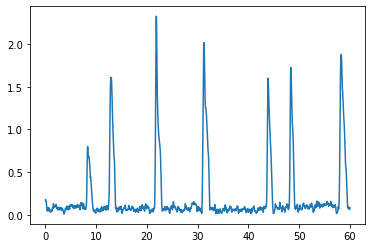

In [16]:
plt.plot(removed_df[1].time[0:10000], removed_df[1].pressure[0:10000])

In [17]:
trials = 3
pressure_thres = 0.25

t_reach = []
t_place = []

double_segments = {}
reaching_seg = {}
placing_seg = {}

for trial in range(0,trials):
    
    df = removed_df[trial]
    double_segments[trial] = {}
    reaching_seg[trial] = {}
    placing_seg[trial] = {}
    
    start_segment_ix = df[df.command_start > 1.0].index
    end_segment_ix = df[df.command_start == 1.0].index

    for k in range(0,len(start_segment_ix)):

        i_s = start_segment_ix[k]
        i_e = end_segment_ix[k]

        double_segments[trial][k] = df.loc[i_s:i_e].copy()
        seg_slct = double_segments[trial][k].copy()
        
        try:
            start_contact_ix = seg_slct[seg_slct.pressure > pressure_thres].index[0]
            end_contact_ix = seg_slct[(seg_slct.pressure < pressure_thres) & (seg_slct.index > start_contact_ix)].index[0]
        except:
            print('Error:')
            print('trial: {}, segment: {}'.format(trial,k))
        else:
            reaching_seg[trial][k] = seg_slct.loc[0:start_contact_ix-1]
            placing_seg[trial][k] = seg_slct.loc[start_contact_ix:end_contact_ix]

            reaching_seg[trial][k].reset_index(drop=True,inplace=True)
            placing_seg[trial][k].reset_index(drop=True,inplace=True)

            reaching_seg[trial][k].time = [i - reaching_seg[trial][k].time[0] for i in reaching_seg[trial][k].time]
            placing_seg[trial][k].time = [i - placing_seg[trial][k].time[0] for i in placing_seg[trial][k].time]
            
            placing_seg[trial][k].command_start[0]= reaching_seg[trial][k].command_start[0]
            placing_seg[trial][k].prev_command[0]= reaching_seg[trial][k].prev_command[0]
            
            t_reach.append(reaching_seg[trial][k].time.iloc[-1])
            t_place.append(placing_seg[trial][k].time.iloc[-1])
        

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Error:
trial: 1, segment: 0


In [18]:
try:
    del reaching_seg[1][4]
    del placing_seg[1][4]
    
except KeyError:
    print("Key 'testing' not found")

275

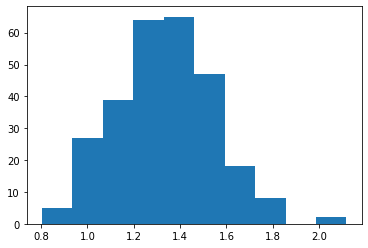

In [19]:
plt.hist(t_place)
len(t_place)

1.6140000000000327

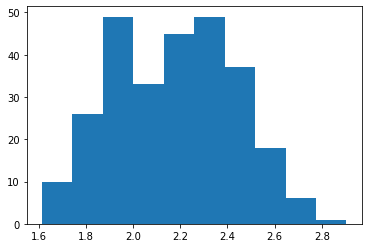

In [20]:
t_reach = pd.Series(t_reach)
plt.hist(t_reach[t_reach<5])
len(t_reach)
a = t_reach[t_reach<5]
np.mean(a)
np.min(a)

In [21]:
reaching_seg[0][0][reaching_seg[0][0].time<1]

,time,E1,E2,E3,S1,S2,S3,T1,T2,T3,...,T2_dd,T3_dd,BB_dd,TB_dd,AD_dd,PM_dd,ED_dd,pressure_dd,command_start,prev_command
0,0.000,4.062449,35.898322,-4.437775,27.970771,59.271687,22.883556,-19.389388,-6.092223,-0.763553,...,0.802725,-3.841148,0.002352,0.014950,-0.010284,0.001861,0.015146,0.433574,2.0,0.0
1,0.006,3.846032,34.959568,-4.427172,27.238644,61.722434,22.348438,-19.472318,-6.077849,-0.832247,...,0.270162,-1.296352,0.002228,0.015525,-0.010199,0.001880,0.014902,34.649576,-1.0,-1.0
2,0.012,3.635819,34.021452,-4.416576,26.507014,64.171513,21.813683,-19.555191,-6.063484,-0.900893,...,-0.273299,1.300479,0.002103,0.016086,-0.010110,0.001897,0.014652,74.634952,-1.0,-1.0
3,0.018,3.431779,33.085228,-4.406002,25.776860,66.615655,21.280006,-19.637897,-6.049149,-0.969401,...,-0.805898,3.845319,0.001975,0.016636,-0.010017,0.001914,0.014397,46.343681,-1.0,-1.0
4,0.024,3.233872,32.152087,-4.395462,25.049111,69.051746,20.748088,-19.720330,-6.034861,-1.037684,...,-1.313394,6.270086,0.001846,0.017173,-0.009919,0.001930,0.014137,10.657604,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.972,0.054586,0.017345,-4.031623,-0.012176,152.956461,2.422112,-22.551601,-5.548860,-3.385652,...,1.114886,-2.363460,0.003691,0.010308,0.062895,0.000797,-0.022609,-3.916378,-1.0,-1.0
163,0.978,0.060070,0.030137,-4.031862,-0.002172,152.922298,2.429952,-22.550955,-5.548680,-3.384996,...,1.141090,-2.383263,0.003979,0.010151,0.063358,0.000801,-0.022439,-40.578591,-1.0,-1.0
164,0.984,0.065963,0.042014,-4.032096,0.007120,152.890466,2.437309,-22.550426,-5.548459,-3.384427,...,1.167496,-2.402737,0.004267,0.009997,0.063812,0.000806,-0.022264,-77.760534,-1.0,-1.0
165,0.990,0.072288,0.052974,-4.032326,0.015697,152.860967,2.444185,-22.550014,-5.548194,-3.383946,...,1.194096,-2.421921,0.004557,0.009847,0.064257,0.000811,-0.022083,-49.368652,-1.0,-1.0


In [81]:
time_interval_reach = 0.7#s

ix_reach = reaching_seg[0][0][reaching_seg[0][0].time<time_interval_reach].index[-1]

p_ix_reach = np.linspace(0,ix_reach,6).astype(int)

#####

time_interval_place = 0.7#s

ix_place = placing_seg[0][0][placing_seg[0][0].time<time_interval_place].index[-1]

p_ix_place = np.linspace(0,ix_place,6).astype(int)

In [82]:
labels = ['_1','_2','_3','_4','_5','_6']
cols = list(reaching_seg[0][0].drop(['time','command','prev_command','command_start'],axis=1).columns)
new_label = [col + label for label in labels for col in cols ]

new_label_reach = new_label + ['reach','trial','segment','time_end']
new_label_place = new_label + ['current_pos','next_pos','trial','segment','time_end']

In [83]:
dataset_reach = condense(reaching_seg,p_ix_reach, new_label = new_label_reach ) 
dataset_place = condense(placing_seg,p_ix_place, new_label = new_label_place,  place=1)

In [84]:
##### SUMMARISE DATASET
# quickest reach time was 1.614: prediction before that, start: 0.5s
#
# 2 Problems: 1. reaching, 2. placing
#
# reaching & placing: category, average speed (knowledge from experiment)
# 
# segment starts when they move not from command signal?
#
# reaching_seg[trial][segment_num]
# placing_seg[trial][segment_num]

def condense(segments, p_ix, new_label, place=0):

    trials =3

    ### REACHING
    # Time 0.5s, 6 points
    # first segment is removed

    df_comp = pd.DataFrame()

    for trial in range(0,trials):

        for seg in range(0,len(segments[trial])):

            if seg in segments[trial]:

                subset = segments[trial][seg].loc[p_ix]
                subset = subset.drop(['time','command','prev_command','command_start'],axis=1)

                df = pd.DataFrame(np.array(subset).ravel()).T
            
                if (place):
                    df['current_pos'] = segments[trial][seg].prev_command
                    df['next_pos'] = segments[trial][seg].command_start
                else:
                    df['reach'] = segments[trial][seg].prev_command
                
                df['trial'] = trial
                df['segment'] = seg
                df['time_end'] = segments[trial][seg].iloc[-1].time

                df_comp = df_comp.append(df,ignore_index=True)

    df_comp.columns = new_label
    
    if not place:
        dataset =df_comp.drop(df_comp[df_comp.reach ==0].index,axis=0).reset_index(drop=True)
    else:
        dataset =df_comp.drop(df_comp[df_comp.current_pos ==0].index,axis=0).reset_index(drop=True)
    
    return dataset

In [91]:
dataset_reach

,E1_1,E2_1,E3_1,S1_1,S2_1,S3_1,T1_1,T2_1,T3_1,BB_1,...,BB_dd_6,TB_dd_6,AD_dd_6,PM_dd_6,ED_dd_6,pressure_dd_6,reach,trial,segment,time_end
0,72.253929,89.030685,26.150529,21.726564,-49.830156,20.948831,-17.979301,-2.993113,-1.106940,0.001499,...,0.016881,0.027944,0.072222,0.000101,0.012736,-21.808313,2.0,0,1,2.214
1,77.027100,88.788132,23.214279,21.408355,-63.182854,22.963678,-15.682779,0.435545,0.022459,0.001042,...,0.018533,0.017597,0.078803,0.001014,0.015554,5.831950,3.0,0,2,2.316
2,73.371591,86.700938,20.582065,27.346014,-64.592266,28.969223,-14.388443,-0.216548,0.323046,0.001766,...,0.011145,0.026934,0.041758,0.000781,0.014678,-7.447318,4.0,0,3,2.226
3,75.670993,87.315029,21.283304,25.425284,-63.857038,27.096409,-14.851425,-0.782172,0.888211,0.001307,...,0.015483,0.010479,0.076075,0.001249,0.009196,-1.970718,3.0,0,4,2.370
4,72.300523,87.034020,19.327883,25.905120,-58.985012,26.673713,-16.194544,-2.586347,1.623215,0.002505,...,0.010515,0.005475,0.048574,0.000976,0.010783,-2.322881,5.0,0,5,1.956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,71.080012,85.723125,23.079991,21.189578,-53.048350,22.341883,-16.030112,-3.974444,1.100301,0.001376,...,0.012820,0.001349,0.085852,-0.000598,0.007660,-1.734527,3.0,2,87,2.640
266,70.620502,85.725964,23.755951,20.999800,-53.946098,22.731335,-14.949926,-5.879012,0.112387,0.001788,...,0.016269,-0.001768,0.078586,0.000476,0.011728,-21.101885,6.0,2,88,1.860
267,71.494163,85.779277,24.247812,21.323809,-55.331704,23.621624,-14.605722,-7.641247,0.294588,0.001309,...,0.014606,0.005100,0.109455,-0.001047,0.009360,-6.459641,2.0,2,89,2.670
268,69.620121,85.191684,21.163465,23.527708,-56.591947,25.970373,-14.193217,-7.335839,0.899912,0.002331,...,-0.000227,0.016071,0.055203,0.000420,0.009306,52.820733,4.0,2,90,2.340


In [86]:
#dataset =df_comp.drop(df_comp[df_comp.reach ==0].index,axis=0).reset_index(drop=True)

In [87]:
path = os.path.abspath("../data/03_modelling/dataset_reach.csv")
dataset_reach.to_csv(path) #BUG: ADD BACK IN

path = os.path.abspath("../data/03_modelling/dataset_place.csv")
dataset_place.to_csv(path)

import pickle

pickle_out = open("../data/03_modelling/dict.reaching_segments","wb")
pickle.dump(reaching_seg, pickle_out)
pickle_out.close()  

pickle_out = open("../data/03_modelling/dict.placing_segments","wb")
pickle.dump(placing_seg, pickle_out)
pickle_out.close()  